In [1]:
# Set directory
import os
%cd ../

/Users/gregoryyampolsky/Downloads/RentEstimateProject


In [2]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
from src import preprocessing
from src.modeling import Modeler
from src.inference import predict_market_rent
import scipy.stats as stats
import joblib
from pathlib import Path
import shap
import numpy as np
import seaborn as sns
import xgboost as xgb



Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
#read the csv
df = pd.read_csv('data/TrainingSet.csv')
print(df.shape)
df.head()

(274075, 8)


,Close Date,Close Price,Latitude,Longitude,Bedrooms,Bathrooms,Square Feet,Year Built
0,12/17/2024,4800.0,26.257621,-81.711571,4,3.0,2259,2004
1,12/17/2024,3700.0,34.041742,-84.044686,5,6.0,2951,2002
2,12/17/2024,2400.0,33.205474,-96.664503,4,2.0,1788,2000
3,12/17/2024,1770.0,27.756995,-82.648477,3,1.0,944,1955
4,12/17/2024,1995.0,32.627490,-97.328963,3,2.0,1360,2010


In [4]:
final_df = preprocessing.preprocess_data(df)
final_df.head()

,Close Date,Close Price,Latitude,Longitude,Bedrooms,Bathrooms,Square Feet,Year Built,ZHI,DistanceToTransit
0,12/17/2024,4800.0,26.257621,-81.711571,4,3.0,2259,2004,208912.111662,1684.942919
1,12/17/2024,3700.0,34.041742,-84.044686,5,6.0,2951,2002,230742.445051,799.887679
2,12/17/2024,2400.0,33.205474,-96.664503,4,2.0,1788,2000,159331.364867,15612.486925
3,12/17/2024,1770.0,27.756995,-82.648477,3,1.0,944,1955,265868.815132,189.133627
4,12/17/2024,1995.0,32.627490,-97.328963,3,2.0,1360,2010,159331.364867,760.209205


In [5]:
target_col = "Close Price"  
Modeler=Modeler(final_df, target_col)
Modeler.train_test_split(0.3)

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


models = {
    # linear regression
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },
    # decision tree 
    'decision_tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5, 10]
        }
    },
    # hist gradient boosting
    'HistGradientBoostingRegressor': {
        'model': HistGradientBoostingRegressor(random_state=42),
        'params': {
            'model__max_depth': [None, 10, 20],
            'model__min_samples_leaf': [2, 5, 10]
        }
    },
    # xgboost (slim grid for speed)
    'XGBoost': {
        'model': XGBRegressor(
            tree_method='hist',
            random_state=42,
            n_estimators=600,           
            learning_rate=0.06,        
            subsample=0.8,
            colsample_bytree=0.8,
            max_bin=128,               
            n_jobs=-1
        ),
        'params': {
            'model__objective': ['reg:squarederror'],     # single objective to reduce combos
            'model__max_depth': [4, 6],                   # fewer, shallower trees
            'model__min_child_weight': [3, 6],            # regularization via min child weight
            'model__gamma': [0, 1],                       # split loss threshold
            'model__reg_alpha': [0, 0.01],                # L1
            'model__reg_lambda': [1, 10]                  # L2
        }
    },
    # ANN 
    'ANN': {
        'model': MLPRegressor(
            random_state=42,
            max_iter=400,
            early_stopping=True,
            n_iter_no_change=5,
            tol=1e-3
        ),
        'params': {
            'model__hidden_layer_sizes': [(64,), (64, 32)],
            'model__activation': ['relu'],
            'model__learning_rate_init': [1e-3, 5e-4],
            'model__alpha': [1e-4, 1e-3],
            'model__batch_size': [128]
        }
    }
}

results = Modeler.model_evals(models=models)
results


  0%|          | 0/5 [00:00<?, ?it/s]

Training LinearRegression...


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 20%|██        | 1/5 [00:01<00:06,  1.54s/it]

________________________________________
Training decision_tree...


 40%|████      | 2/5 [00:07<00:12,  4.30s/it]

________________________________________
Training HistGradientBoostingRegressor...


 60%|██████    | 3/5 [00:13<00:10,  5.09s/it]

________________________________________
Training XGBoost...


 80%|████████  | 4/5 [00:57<00:20, 20.38s/it]

________________________________________
Training ANN...


100%|██████████| 5/5 [01:53<00:00, 22.79s/it]

________________________________________


,Model Name,Best Parameters,Training_Latency,Train_MSE,Test_MSE,TrainR2,TestR2
3,XGBoost,"{'model__gamma': 0, 'model__max_depth': 6, 'mo...",1.555527,140573.767499,177879.270753,0.789131,0.733276
2,HistGradientBoostingRegressor,"{'model__max_depth': None, 'model__min_samples...",0.923011,176779.693091,193178.091535,0.734819,0.710336
4,ANN,"{'model__activation': 'relu', 'model__alpha': ...",25.208584,225857.357082,232120.675571,0.661200,0.651943
1,decision_tree,"{'model__max_depth': 10, 'model__min_samples_s...",0.881548,200387.235595,246487.630994,0.699407,0.630400
0,LinearRegression,{},0.290590,386844.307548,381285.004539,0.419709,0.428276


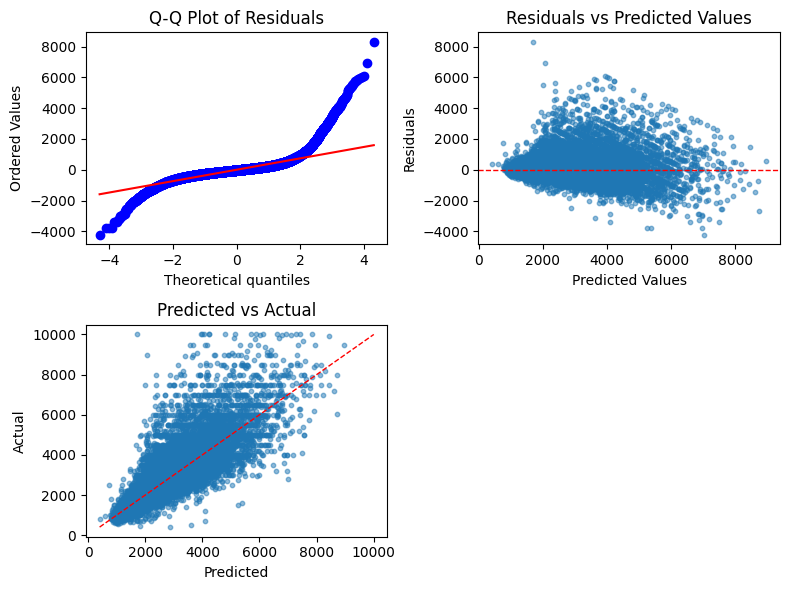

Residuals stats:
mean: 0.5951286247977822, std: 421.7595048996497, skew: 2.857815162518042, kurtosis: 28.19676949376961


In [7]:
# Compact diagnostics: 2 plots on the first row, 1 on the next

best_model = Modeler.best_model
y_pred = best_model.predict(Modeler.X_test)
residuals = Modeler.y_test - y_pred

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

# Q-Q plot (top-left)
stats.probplot(residuals, dist="norm", plot=ax1)
ax1.set_title("Q-Q Plot of Residuals")

# Residuals vs Predicted (top-right)
ax2.scatter(y_pred, residuals, alpha=0.5, s=10)
ax2.axhline(0, color='red', linestyle='--', linewidth=1)
ax2.set_xlabel("Predicted Values")
ax2.set_ylabel("Residuals")
ax2.set_title("Residuals vs Predicted Values")

# Predicted vs Actual (bottom-left)
ax3.scatter(y_pred, Modeler.y_test, alpha=0.5, s=10)
low = float(min(Modeler.y_test.min(), y_pred.min()))
high = float(max(Modeler.y_test.max(), y_pred.max()))
ax3.plot([low, high], [low, high], 'r--', linewidth=1)
ax3.set_xlabel("Predicted")
ax3.set_ylabel("Actual")
ax3.set_title("Predicted vs Actual")

# Hide unused bottom-right subplot
ax4.axis('off')

plt.tight_layout()
plt.show()
print('Residuals stats:')
print(f"mean: {residuals.mean()}, std: {residuals.std()}, skew: {residuals.skew()}, kurtosis: {residuals.kurtosis()}")

In [8]:
Modeler.save_models()

Models saved to models/
Model results saved to models/model_results.csv


In [9]:
Modeler.train_final_model()

Final model saved to models/final_model.joblib


In [10]:
# Load final (best) model from disk and generate predictions on test set

test_path='data/TestSet.csv'
print(f"Reading test data from: {test_path}")
raw_test_df = pd.read_csv(test_path)
print(raw_test_df.head(),'\n')
print(predict_market_rent(raw_test_df).head())

Reading test data from: data/TestSet.csv
    Latitude   Longitude  Bedrooms  Bathrooms  Square Feet  Year Built
0  33.615438 -112.065775         4        2.0         2489        1985
1  29.755359  -95.781869         3        2.0         2204        1978
2  25.996436  -80.253141         2        2.0         1355        1982
3  39.911228  -83.093273         4        3.0         1861        2002
4  33.442062 -112.278588         4        2.0         1866        2004 

Predictions written to .data/exports/final_predictions_20251110_004456.csv (rows=10000)
    Latitude   Longitude  Bedrooms  Bathrooms  Square Feet  Year Built  \
0  33.615438 -112.065775         4        2.0         2489        1985   
1  29.755359  -95.781869         3        2.0         2204        1978   
2  25.996436  -80.253141         2        2.0         1355        1982   
3  39.911228  -83.093273         4        3.0         1861        2002   
4  33.442062 -112.278588         4        2.0         1866        2004   

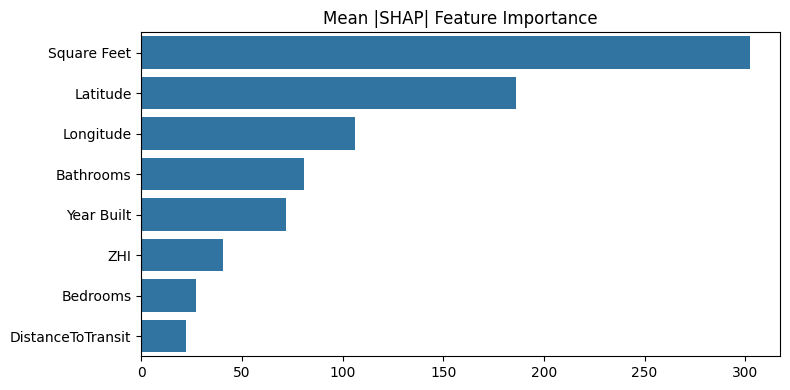

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


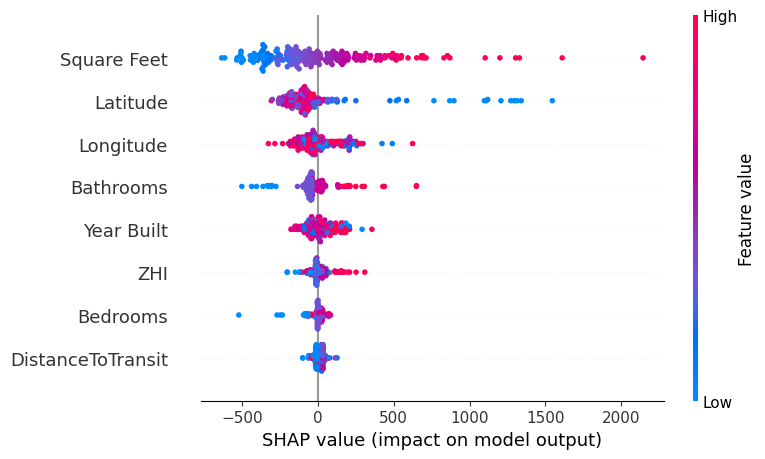

In [11]:
# SHAP feature importance (XGBoost, simple, labeled)

test_path='data/TestSet.csv'
raw_test_df = pd.read_csv(test_path)
processed_test_df = preprocessing.preprocess_data(raw_test_df)

n_sample = min(200, len(processed_test_df))
X = processed_test_df.sample(n_sample, random_state=42)
best_pipeline = joblib.load('./models/final_model.joblib')

# Extract model once
model = best_pipeline.named_steps['model'] if hasattr(best_pipeline, 'named_steps') else best_pipeline

# Preprocess sampled data (same as during training)
preprocessor = best_pipeline.named_steps.get('preprocessor') if hasattr(best_pipeline, 'named_steps') else None
X_model = preprocessor.transform(X) if preprocessor is not None else X

# Compute SHAP contributions (last column is bias -> drop once)
dmat = xgb.DMatrix(X_model)
shap_values = model.get_booster().predict(dmat, pred_contribs=True)
shap_values = np.asarray(shap_values)[:, :-1]  # drop bias ONLY once

# Ensure output dir
Path('models').mkdir(parents=True, exist_ok=True)

# Mean absolute SHAP and sorted bar plot (descending)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_names = ['Latitude', 'Longitude', 'ZHI', 'Year Built',
                 'Bedrooms', 'Square Feet', 'Bathrooms', 'DistanceToTransit']
order = np.argsort(mean_abs_shap)[::-1]
mean_abs_shap_sorted = mean_abs_shap[order]
feature_names_sorted = [feature_names[i] for i in order]

plt.figure(figsize=(8, 4))
sns.barplot(x=mean_abs_shap_sorted, y=feature_names_sorted, orient='h')
plt.title('Mean |SHAP| Feature Importance')
plt.tight_layout()
plt.savefig('Images/feature_importance.png', dpi=300)
plt.show()

# Beeswarm plot (raw feature values; shapes now match)
plt.figure(figsize=(8, 5))
shap.summary_plot(shap_values, X[feature_names], show=False)
plt.tight_layout()
plt.savefig('Images/feature_importance_beeswarm.png', dpi=300)
plt.show()
